# Comparing CollaGAN-3 with Pix2Pix and StarGAN

This notebook compares the images generated with CollaGAN-3 (receiving 3 source images) with Pix2Pix and StarGAN
(both receiving a single source image).

The CollaGAN model used no dropout during training. For the metrics, the Pix2Pix and StarGAN translated images from all the domains 
other than the target, and we averaged the values.

In [1]:
import gc
import logging
from time import time

import logging_utils

from ModelProxy import Pix2PixModelProxy, StarGANModelProxy, CollaGANModelProxy

logging_utils.configure()

model_loaders = {
    "pix2pix": lambda: Pix2PixModelProxy("models/pix2pix"),
    # 'stargan': lambda: StarGANModelProxy(
    #     'models/selection/stargan-capacity-and-cost/stargan-paired/all,lambda-l1-100.0,lambda-domain-1.0,lambda-reconstruction-10.0capacity-4/models/py/generator'), # went to sbgames'24 originally
    "stargan": lambda: StarGANModelProxy("models/stargan"),
    "collagan": lambda: CollaGANModelProxy("models/collagan"),
}

2025-05-30 14:06:59.019771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 14:06:59.050284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 14:06:59.050327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 14:06:59.068961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-30 14:07:00.531999: W tensorflow/compiler/tf

## Loads the Larger Dataset

These tests use the Larger dataset.


In [2]:
from dataset_utils import DatasetLoader


dataset_loader = DatasetLoader("all", "test", limit=None)

## Generates Images for a Qualitative Analysis


In [3]:
from image_utils import show_collagan3_and_baseline_comparison
import tensorflow as tf

def generate_batch_with_each_model(number_of_4batches=1, sample_numbers=None):
    mode = "random_batch" if sample_numbers is None else "specific_samples"
    batch_transpose = None
    if mode == "specific_samples":
        batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
        batch = tf.stack(batch, axis=0)
        batch_transpose = batch
    elif mode == "random_batch":
        # loads a batch of images
        batch = next(iter(dataset_loader.dataset.shuffle(600).batch(number_of_4batches*4).take(1)))
        batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])
    
    genned_images = []    
    target_indices = tf.repeat(tf.range(0, 4), [number_of_4batches] * 4)
    target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
    dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
    source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
    for model_name, model_loader in model_loaders.items():
        # loads the model into memory
        generator = model_loader()    
        # generates the images
        if model_name in ['pix2pix', 'stargan', 'stargan-study-network-and-sampler']:
            fake_images = []
            for sample_idx, target_domain in enumerate(target_indices):
                fake_images_of_example = []
                for source_domain in range(4):
                    if source_domain == target_domain:
                        single_fake_image = tf.ones_like(target_images[0])[tf.newaxis, ...] * -1.
                    else:
                        single_fake_image = generator.generate(source_domain, target_domain, source_images[sample_idx][:, tf.newaxis, ...])
                    fake_images_of_example += [single_fake_image]
                fake_images_of_example = tf.concat(fake_images_of_example, axis=0)
                fake_images += [fake_images_of_example]
            fake_images = tf.stack(fake_images, axis=0)

        else:
            fake_images = generator.generate_from_multiple(target_indices, source_images)

        genned_images += [fake_images]
        # frees the memory used by the model
        del generator

    # sets the target images in the source images to -1, so it becomes a checkerboard pattern when displaying
    target_in_source_mask = tf.one_hot(target_indices, 4, dtype=tf.float32)[..., tf.newaxis, tf.newaxis, tf.newaxis]
    source_images += target_in_source_mask * -1
    return source_images, target_images, genned_images, ""


starting_test_sample_numbers = stsn = {"tiny": 0, "rm2k": 136, "rmxp": 168, "rmvx": 212, "misc": 273}
example_numbers=[
    stsn["rmxp"]+25,    # rmxp maid lady
    # stsn["misc"]+782,   #   
    stsn["rmxp"]+4,     # rmxp bunny tiara girl
    # stsn["misc"]+207,
    stsn["misc"]+1701,  # misc tiny butt
    # stsn["rm2k"]+20,  #
    stsn["rmxp"]+5,     # rmxp cook
    # stsn["rmvx"]+27,    # rmvx santa
    
    # stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]
imgs_params = generate_batch_with_each_model(1, example_numbers)


2025-05-30 14:07:06 INFO     Start >> Loading Pix2Pix model left-to-back


target_domain tf.Tensor(0, shape=(), dtype=int32)


2025-05-30 14:07:11 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:07:11 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:07:11 INFO     End   >> Loading Pix2Pix model left-to-back
2025-05-30 14:07:12.154441: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-05-30 14:07:13.918791: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


target_domain tf.Tensor(0, shape=(), dtype=int32)


2025-05-30 14:07:14 INFO     Start >> Loading Pix2Pix model front-to-back
2025-05-30 14:07:19 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:07:19 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:07:19 INFO     End   >> Loading Pix2Pix model front-to-back


target_domain tf.Tensor(0, shape=(), dtype=int32)


2025-05-30 14:07:20 INFO     Start >> Loading Pix2Pix model right-to-back
2025-05-30 14:07:25 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:07:25 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:07:25 INFO     End   >> Loading Pix2Pix model right-to-back


target_domain tf.Tensor(1, shape=(), dtype=int32)


2025-05-30 14:07:26 INFO     Start >> Loading Pix2Pix model back-to-left
2025-05-30 14:07:31 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:07:31 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:07:31 INFO     End   >> Loading Pix2Pix model back-to-left


target_domain tf.Tensor(1, shape=(), dtype=int32)


2025-05-30 14:07:31 INFO     Start >> Loading Pix2Pix model front-to-left
2025-05-30 14:07:35 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:07:35 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:07:35 INFO     End   >> Loading Pix2Pix model front-to-left


target_domain tf.Tensor(1, shape=(), dtype=int32)


2025-05-30 14:07:36 INFO     Start >> Loading Pix2Pix model right-to-left
2025-05-30 14:07:41 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:07:41 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:07:41 INFO     End   >> Loading Pix2Pix model right-to-left


target_domain tf.Tensor(2, shape=(), dtype=int32)


2025-05-30 14:07:41 INFO     Start >> Loading Pix2Pix model back-to-front
2025-05-30 14:07:45 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:07:45 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:07:45 INFO     End   >> Loading Pix2Pix model back-to-front


target_domain tf.Tensor(2, shape=(), dtype=int32)


2025-05-30 14:07:46 INFO     Start >> Loading Pix2Pix model left-to-front
2025-05-30 14:07:51 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:07:51 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:07:51 INFO     End   >> Loading Pix2Pix model left-to-front


target_domain tf.Tensor(2, shape=(), dtype=int32)


2025-05-30 14:07:51 INFO     Start >> Loading Pix2Pix model right-to-front
2025-05-30 14:07:57 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:07:57 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:07:57 INFO     End   >> Loading Pix2Pix model right-to-front


target_domain tf.Tensor(3, shape=(), dtype=int32)


2025-05-30 14:07:58 INFO     Start >> Loading Pix2Pix model back-to-right
2025-05-30 14:08:05 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:08:05 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:08:05 INFO     End   >> Loading Pix2Pix model back-to-right


target_domain tf.Tensor(3, shape=(), dtype=int32)


2025-05-30 14:08:06 INFO     Start >> Loading Pix2Pix model left-to-right
2025-05-30 14:08:11 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:08:11 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:08:11 INFO     End   >> Loading Pix2Pix model left-to-right


target_domain tf.Tensor(3, shape=(), dtype=int32)


2025-05-30 14:08:11 INFO     Start >> Loading Pix2Pix model front-to-right
2025-05-30 14:08:16 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:08:16 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:08:16 INFO     End   >> Loading Pix2Pix model front-to-right
2025-05-30 14:08:24 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:08:24 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.


target_domain tf.Tensor(0, shape=(), dtype=int32)


2025-05-30 14:08:25.389282: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


target_domain tf.Tensor(0, shape=(), dtype=int32)
target_domain tf.Tensor(0, shape=(), dtype=int32)
target_domain tf.Tensor(1, shape=(), dtype=int32)
target_domain tf.Tensor(1, shape=(), dtype=int32)
target_domain tf.Tensor(1, shape=(), dtype=int32)
target_domain tf.Tensor(2, shape=(), dtype=int32)
target_domain tf.Tensor(2, shape=(), dtype=int32)
target_domain tf.Tensor(2, shape=(), dtype=int32)
target_domain tf.Tensor(3, shape=(), dtype=int32)
target_domain tf.Tensor(3, shape=(), dtype=int32)
target_domain tf.Tensor(3, shape=(), dtype=int32)


2025-05-30 14:08:36 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:08:36 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 14:08:38.277251: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-30 14:08:38.292991: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-30 14:08:38.500393: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.89GiB with freed_by_count=0. The

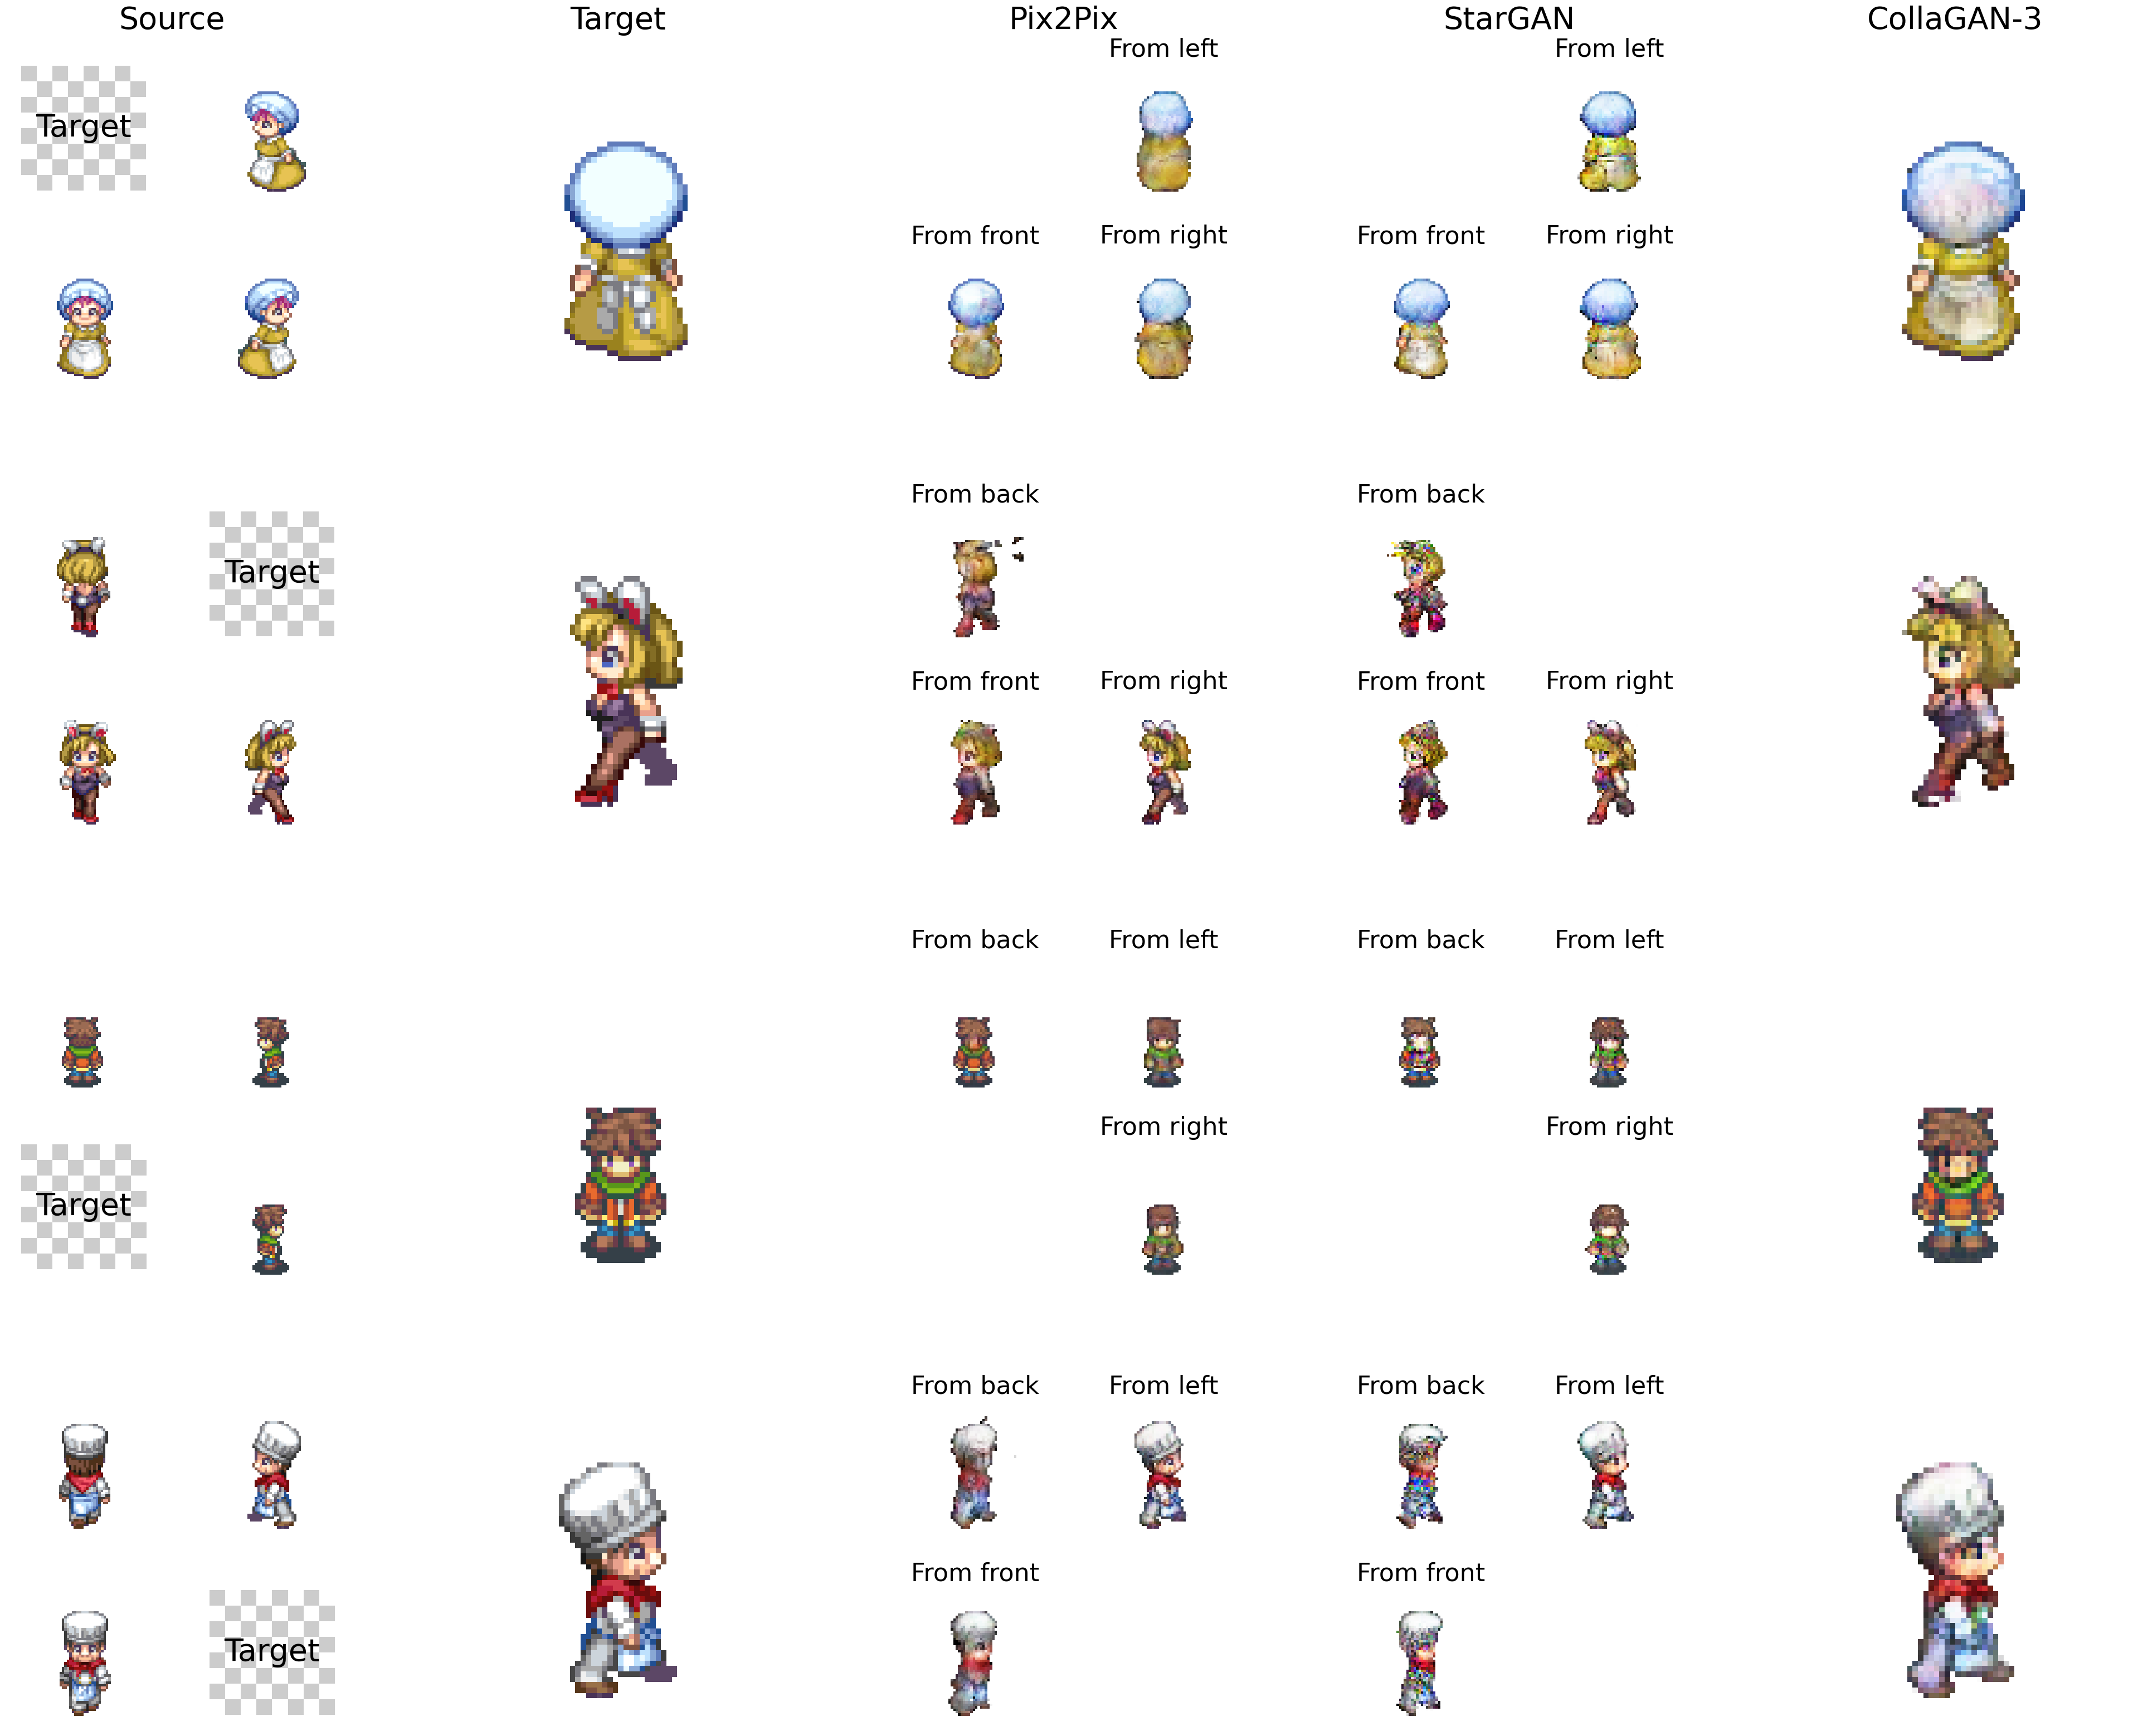

In [4]:
from matplotlib import pyplot as plt


f = show_collagan3_and_baseline_comparison(*imgs_params)
f.patch.set_alpha(0.0)
plt.savefig("output/collagan_compared_with_baseline.png", format="png", transparent=True)
